# Import the libraries

In [ ]:
# Install required libs
!pip install tensorflow==2.11.0 youtube-dl moviepy
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/TahaAnwar/pafy.git to /tmp/pip-install-jjbyn4i6/pafy_f6ed374653354b3bb7e8711a438e0fcf
  Running command git clone --filter=blob:none --quiet https://github.com/TahaAnwar/pafy.git /tmp/pip-install-jjbyn4i6/pafy_f6ed374653354b3bb7e8711a438e0fcf
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb
  Preparing metadata (setup.py) ... done


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline 

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import TimeDistributed, MaxPooling2D, Dropout, Conv2D, Flatten, Dense, LSTM, MaxPooling3D, ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
print(tf.__version__)

2.11.0


And will set `Numpy`, `Python`, and `Tensorflow` seeds to get consistent results on every execution.

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# Step 1: Download and Visualize the data

## **<font style="color:rgb(134,19,348)">Step 1: Download and Visualize the Data with its Labels</font>**

In the first step, we will download and visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [UCF101 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF101.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:



In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
#Extract the Dataset
!unrar x UCF50.rar

For visualization, we will pick `20` random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( `20` random videos ) of the dataset.

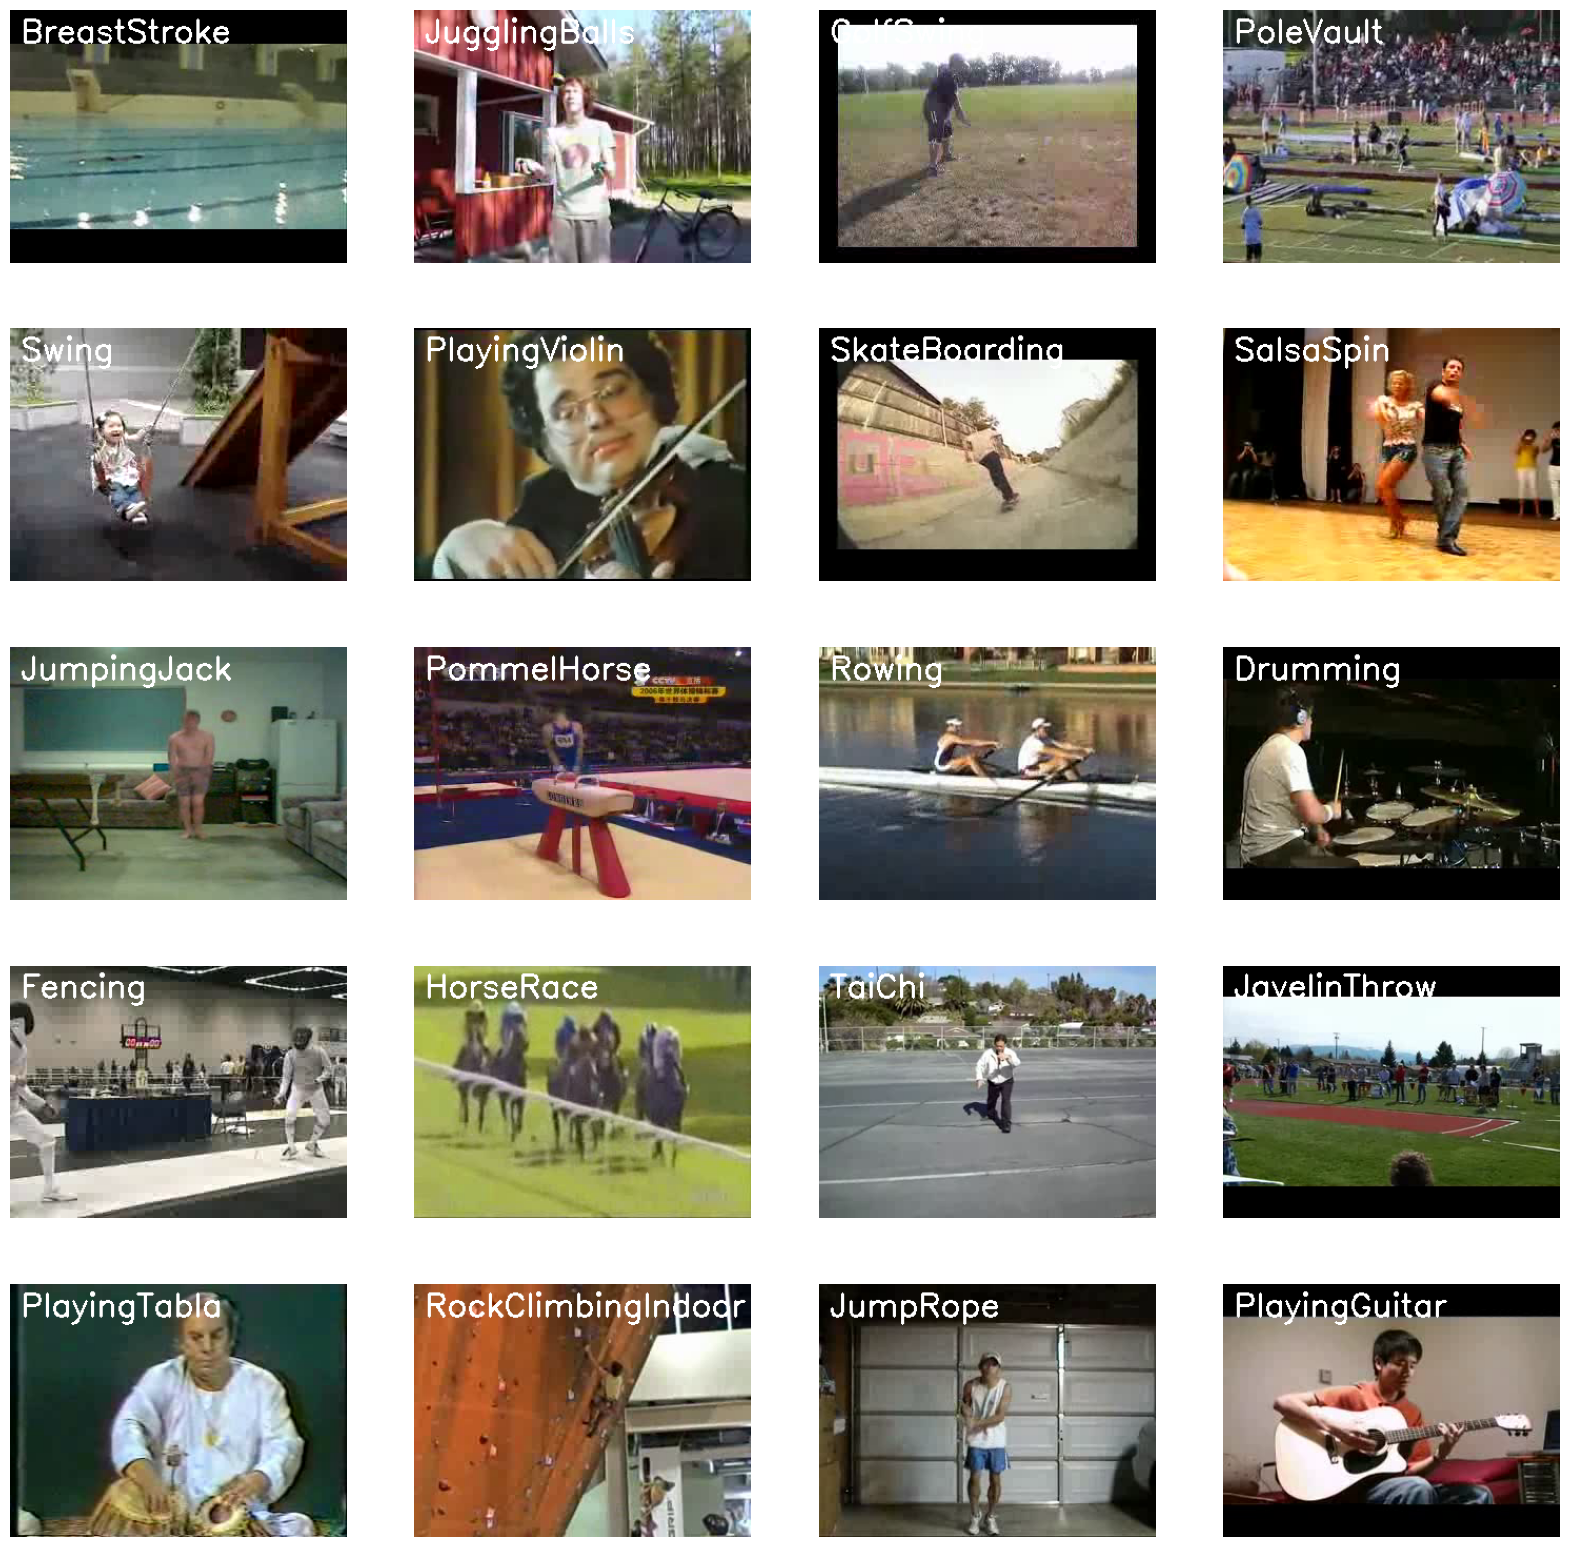

In [ ]:
# Create matplotlib figure
plt.figure(figsize=(20,20))

# Get the name of all classes
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 rnadom value to visualise
random_range = random.sample(range(len(all_classes_names)), 20)

# Interating through all the generated random values
for counter, random_index in enumerate(random_range, 1):
  # Retrieve a class name using random inedx
  sel_class_name = all_classes_names[random_index]
  # Retrieve list of all video files
  vid_file_name_list = os.listdir(f'UCF50/{sel_class_name}')
  # Randomly select a video file from the list retrieved from sel_calss_name
  sel_video_file_name = random.choice(vid_file_name_list)
  # Initialize a VideoCapture to read from the video file
  video_reader = cv2.VideoCapture(f'UCF50/{sel_class_name}/{sel_video_file_name}')
  # Read the first frame of the video file
  _, bgr_frame = video_reader.read()
  # Release the VideoCapture
  video_reader.release()
  # Convert the frame of the BGR into RGB format.
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  # Write the class name on the video frame.
  cv2.putText(rgb_frame, sel_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
  # Display the frame.
  plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

# Step 2: Preprocess the dataset

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "UCF-101"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = os.listdir('UCF-101')

FileNotFoundError: ignored

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

## Create Function to extract, resize and normalize frames

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames. 

In [ ]:
video_r = cv2.VideoCapture('/content/UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi')
frame_count = int(video_r.get(cv2.CAP_PROP_FRAME_COUNT))
frame_count
skip_frames = max(int(frame_count/SEQUENCE_LENGTH), 1)
skip_frames
# each 8 rames get on frame to each for select 20 frame
 

3

In [ ]:
def frames_extraction(video_path):
  ''' 
  This func will extract the required frames from a video after resizing and normalizing them.
  Args:
    video_path: The path of the video in the disk
  Returns:
      frames_list: a list containig the resized and normalized frames
  '''

  # A list to store a video 
  frames_list = []
  # Read video file 
  video_reader = cv2.VideoCapture(video_path)
  # Get the total num of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  # Calculate the interval after which frames will be added to the list
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  # iterate throgh the video frame
  for frame_counter in range(SEQUENCE_LENGTH):
    # Set the cuurent frame position of the video
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
    # Read the frame from the video.
    success, frame = video_reader.read()
    # Check if Video frame is not successfully read then break the loop
    if not success:
      break
    # Resize the frame 
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    # Normalize
    normalized_fram = resized_frame / 255
    # Append the result
    frames_list.append(normalized_fram)
  # Releas the VideoCapture
  video_reader.release()
  # Return frame_list
  return frames_list


### Create func for Dataset Creation

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def create_dataset():
  '''
  This function will extract the data of the selected classes and create the required dataset.
  Returns:
  features:          A list containing the extracted frames of the videos.
  labels:            A list containing the indexes of the classes associated with the videos.
  video_files_paths: A list containing the paths of the videos in the disk.
  '''

  # Declared Empty Lists to store the features, labels and video file path values.
  features = []
  labels = []
  video_files_paths = []

  # Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):

    # Display the name of the class whose data is being extracted.
    print(f'Extracting Data of Class: {class_name}')

    # Get the list of video files present in the specific class name directory.
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

# Iterate through all the files present in the files list.
  for file_name in files_list:
    # Get the complete video path.
    video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
    # Extract the frames of the video file.
    frames = frames_extraction(video_file_path)

    # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
    # So ignore the vides having frames less than the SEQUENCE_LENGTH.
    if len(frames) == SEQUENCE_LENGTH:

      # Append the data to their repective lists.
      features.append(frames)
      labels.append(class_index)
      video_files_paths.append(video_file_path)

  # Converting the list to numpy arrays
  features = np.asarray(features)
  labels = np.array(labels)  

  # Return the frames, class index, and video file path.
  return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Nunchucks
Extracting Data of Class: ParallelBars
Extracting Data of Class: Shotput
Extracting Data of Class: FieldHockeyPenalty
Extracting Data of Class: Punch
Extracting Data of Class: BalanceBeam
Extracting Data of Class: BabyCrawling
Extracting Data of Class: HulaHoop
Extracting Data of Class: Lunges
Extracting Data of Class: HammerThrow
Extracting Data of Class: PlayingDaf
Extracting Data of Class: SkateBoarding
Extracting Data of Class: TennisSwing
Extracting Data of Class: ThrowDiscus
Extracting Data of Class: Biking
Extracting Data of Class: BrushingTeeth
Extracting Data of Class: PlayingDhol
Extracting Data of Class: PushUps
Extracting Data of Class: SumoWrestling
Extracting Data of Class: HandstandWalking
Extracting Data of Class: BaseballPitch
Extracting Data of Class: FrontCrawl
Extracting Data of Class: Mixing
Extracting Data of Class: Surfing
Extracting Data of Class: Haircut
Extracting Data of Class: PlayingCello
Extracting Data of Class: Handsta

Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [ ]:
# Using keras's to_categorical method to convert labels into one hot encoder
one_hot_encoded_labels = to_categorical(labels)

# Step 3: Split the data into train and test 



As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

# Step 4: Implement the ConvLSTM Approach



In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_28 (ConvLSTM2D)  (None, 50, 62, 62, 4)    1024      
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 50, 31, 31, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_25 (TimeDi  (None, 50, 31, 31, 4)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_29 (ConvLSTM2D)  (None, 50, 29, 29, 8)    3488      
                                                                 
 max_pooling3d_29 (MaxPoolin  (None, 50, 15, 15, 8)    0         
 g3D)                                                            
                                                      

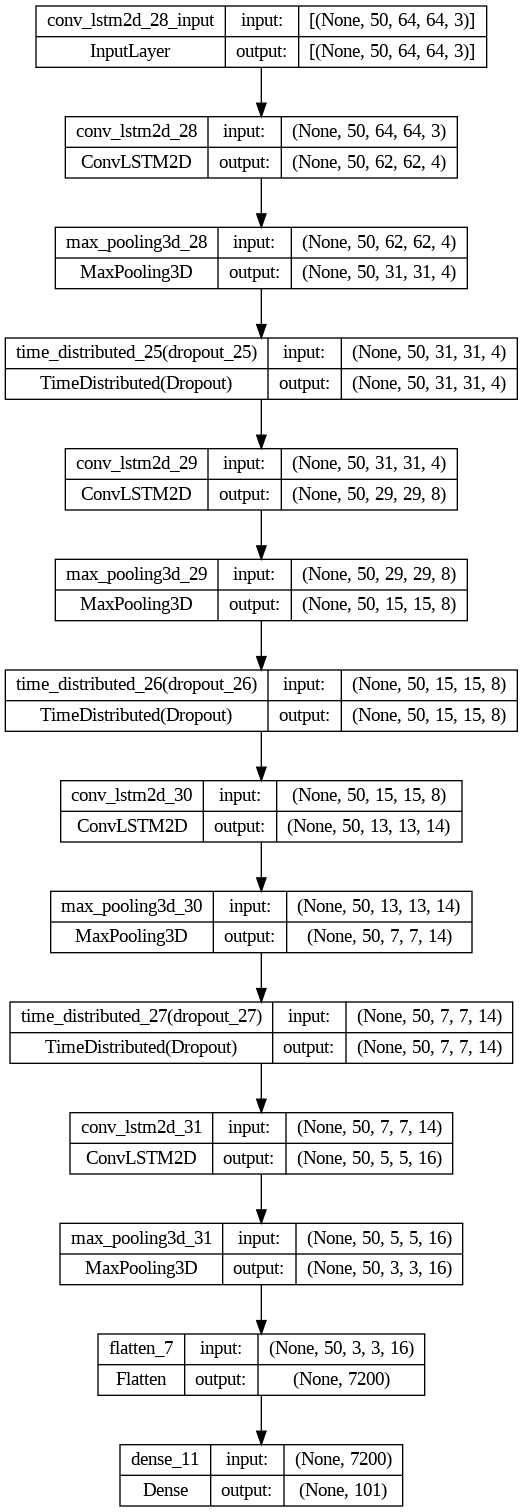

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
16/16 [==============================] - 27s 973ms/step - loss: 0.9394 - accuracy: 0.9375 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/50
16/16 [==============================] - 12s 787ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/50
16/16 [==============================] - 12s 748ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/50
16/16 [==============================] - 14s 864ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/50
16/16 [==============================] - 14s 887ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/50
16/16 [==============================] - 13s 848ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/50
16/16 [==============================] - 14s 883ms/step - loss: 0.0000e+00 - accuracy: 

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

1/1 [==============================] - 1s 521ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

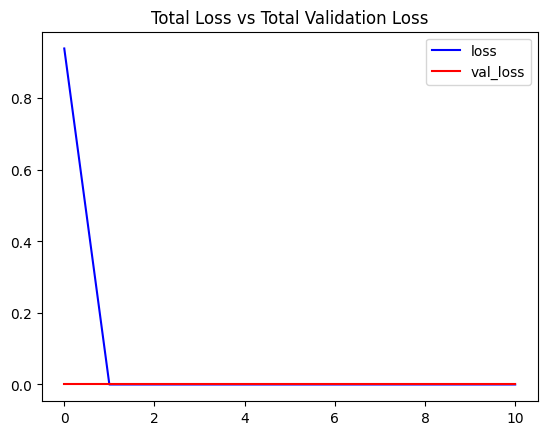

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

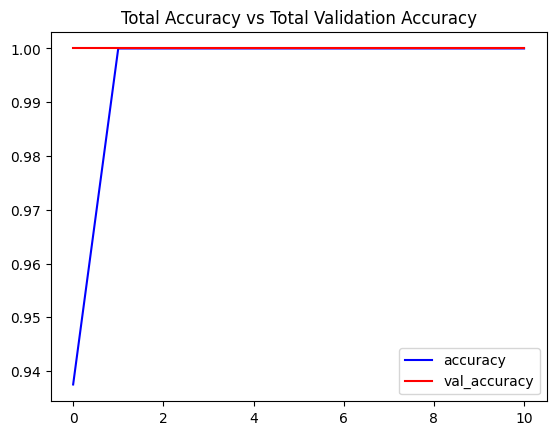

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

# Step 5: Implement the LRCN

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

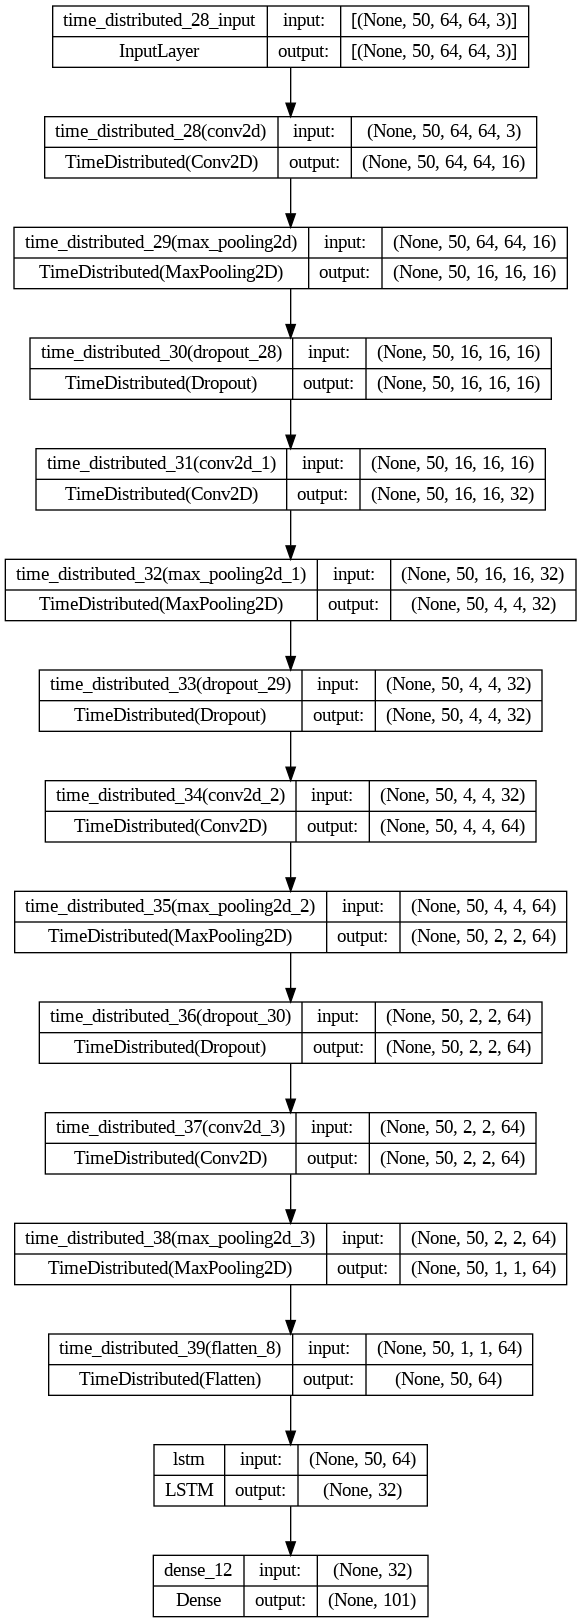

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
16/16 [==============================] - 8s 76ms/step - loss: 3.7514 - accuracy: 0.8125 - val_loss: 2.6458 - val_accuracy: 1.0000
Epoch 2/70
16/16 [==============================] - 0s 22ms/step - loss: 1.6094 - accuracy: 1.0000 - val_loss: 0.7599 - val_accuracy: 1.0000
Epoch 3/70
16/16 [==============================] - 0s 23ms/step - loss: 0.4980 - accuracy: 1.0000 - val_loss: 0.3411 - val_accuracy: 1.0000
Epoch 4/70
16/16 [==============================] - 0s 22ms/step - loss: 0.2375 - accuracy: 1.0000 - val_loss: 0.1677 - val_accuracy: 1.0000
Epoch 5/70
16/16 [==============================] - 0s 20ms/step - loss: 0.1337 - accuracy: 1.0000 - val_loss: 0.1044 - val_accuracy: 1.0000
Epoch 6/70
16/16 [==============================] - 0s 22ms/step - loss: 0.0885 - accuracy: 1.0000 - val_loss: 0.0740 - val_accuracy: 1.0000
Epoch 7/70
16/16 [==============================] - 0s 22ms/step - loss: 0.0652 - accuracy: 1.0000 - val_loss: 0.0567 - val_accuracy: 1.0000
Epoch 8/70
16

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

1/1 [==============================] - 1s 952ms/step - loss: 0.0016 - accuracy: 1.0000


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

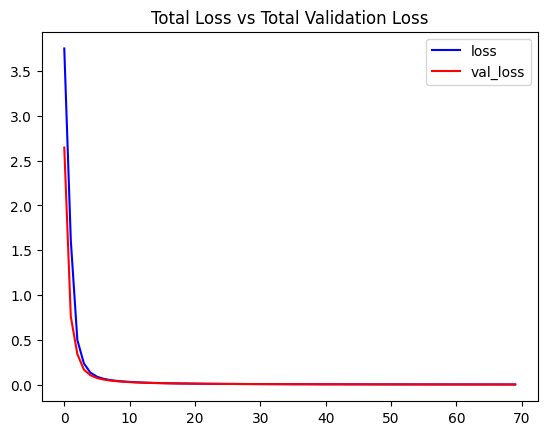

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

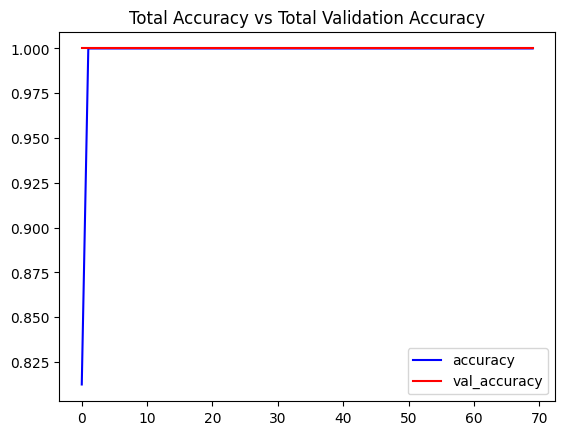

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Step 6: Create a Function To Perform Action Recognition on Videos</font>**

Next, we will create a function **`predict_on_video()`** that will simply read a video frame by frame from the path passed in as an argument and will perform action recognition on video and save the results.

In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_videos()`** and display the output video with the predicted action overlayed on it.

In [ ]:
# Make the Output directory if it does not exist
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)


In [ ]:
# Construct the output video path.
output_video_file_path = f'{test_videos_directory}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video('/content/v3.mp4', output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 32ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
